# 脳のMRI画像の腫瘍分類

## 概要
このnotebookは、脳のMRI画像に腫瘍があるか否かの分類モデルを作成し、利用可能なフォーマットとしてONNXフォーマットに変換されることを目的としています。ONNXフォーマットに変換されたモデルはAPI作成に利用されます。

## 0. データセットの取得
・今回使用するデータセットはkaggle上でMasoud Nickparvar氏によって作成されたBrain Tumor MRI Datasetを使用します。（URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data?select=Training）

In [1]:
# google driveにマウント
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/kaggle"

In [3]:
# kaggleのAPIを使用して、データセットを取得(既に取得済み)
#kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

## 1. 環境設定
### モデル選択
・今回使用するモデルはEfficientNetv2です。現状、CNN系のモデルでは、一番の精度である。そして、今回は転移学習を行うため、パラメータ数を考慮することがないため、ベースラインとして適していると考えました。

In [4]:
!pip install colorama
!pip install timm
!pip install onnx

In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
import seaborn as sns
import random
import gc
import time
import copy

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler

import timm

import onnx

import albumentations as albu
from albumentations.pytorch import transforms as AT

from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL


In [6]:
# 変数の設定
ARGS = {"RANDOM_SEED":123,
        "DATA_PATH":"/content/drive/MyDrive/Colab Notebooks/BrainMRI-images-classification/datasets/",
        "OUT_DIR":"/content/drive/MyDrive/Colab Notebooks/BrainMRI-images-classification/results/",
        "IMAGE_SAVE_DIR":"/content/drive/MyDrive/Colab Notebooks/BrainMRI-images-classification/results/results_images",
        "criterion": "CrossEntropy",
        "clip_grad_norm": "None",
        "model_name":"efficientnet_v2_m",
        'scheduler': 'CosineAnnealingLR',
        'optimizer': 'AdamW',
        'learning_rate': 1e-04,
        "TRAIN_NUM_IMAGES":5714,
        "TEST_NUM_IMAGES":1311,
        "FOLD_NUM":5,
        "epochs":4,
        'num_classes': 2,
        "image_size":480,
        'train_batch_size': 16,
        'test_batch_size': 32,
        'min_lr': 1e-06,
        'T_max': 500,
        "IS_SHUFFLE":True,
        "apex": True,
        'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        }
ARGS

{'RANDOM_SEED': 123,
 'DATA_PATH': '/content/drive/MyDrive/Colab Notebooks/BrainMRI-images-classification/datasets/',
 'OUT_DIR': '/content/drive/MyDrive/Colab Notebooks/BrainMRI-images-classification/results/',
 'criterion': 'CrossEntropy',
 'clip_grad_norm': 'None',
 'model_name': 'efficientnet_v2_m',
 'scheduler': 'CosineAnnealingLR',
 'optimizer': 'AdamW',
 'learning_rate': 0.0001,
 'TRAIN_NUM_IMAGES': 5714,
 'TEST_NUM_IMAGES': 1311,
 'FOLD_NUM': 5,
 'epochs': 4,
 'num_classes': 2,
 'image_size': 480,
 'train_batch_size': 16,
 'test_batch_size': 32,
 'min_lr': 1e-06,
 'T_max': 500,
 'IS_SHUFFLE': True,
 'apex': True,
 'device': device(type='cuda', index=0)}

In [7]:
def get_logger(filename):
  from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
  logger = getLogger(__name__)
  logger.setLevel(INFO)
  handler2 = FileHandler(filename=f"{filename}.log")
  handler2.setFormatter(Formatter("%(message)s"))
  logger.addHandler(handler2)
  return logger

def worker_init_fn(worker_id):
  torch.manual_seed(worker_id)
  random.seed(worker_id)
  np.random.seed(worker_id)
  torch.cuda.manual_seed(worker_id)
  os.environ['PYTHONHASHSEED'] = str(worker_id)

def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  os.environ['PYTHONHASHSEED'] = str(seed)

LOGGER = get_logger(ARGS['OUT_DIR']+'/train')
set_seed(ARGS["RANDOM_SEED"])

In [8]:
def build_metadata(data_path: str, mode: str, num_images: int) -> pd.DataFrame:
  """ディレクトリ内の画像のメタデータをデータフレーム化する
  Args:
    data_path: データセットのディレクトリパス
    mode: 作成したいデータセットの種類（Training or Testing）
    num_images: 画像の枚数

  Returns:
    pd.DataFrame: 該当するmodeのメタデータ
  """

  df = pd.DataFrame(columns=["image_name", "class", "sub_class"], index=range(1, num_images+1))

  image_name_list = []
  class_list = []
  sub_class_list = []
  str2int = {"YES":1, "NO":0}

  for CLASS in os.listdir(data_path + mode):
    for SUB_CLASS in os.listdir(data_path + mode + "/" + CLASS):
      for IMAGE_NAME in os.listdir(data_path + mode + "/" + CLASS + "/" + SUB_CLASS):
        image_name_list.append(IMAGE_NAME)
        class_list.append(CLASS)
        sub_class_list.append(SUB_CLASS)

  df["image_name"] = image_name_list
  df["class"] = class_list
  df["class_int"] = df["class"].map(str2int)
  df["sub_class"] = sub_class_list

  return df

train_df = build_metadata(data_path=ARGS["DATA_PATH"], mode="Training", num_images=ARGS["TRAIN_NUM_IMAGES"])
test_df = build_metadata(data_path=ARGS["DATA_PATH"], mode="Testing", num_images=ARGS["TEST_NUM_IMAGES"])
display(train_df)
display(test_df)

,image_name,class,sub_class,class_int
1,Tr-gl_0220.jpg,YES,glioma,1
2,Tr-gl_0236.jpg,YES,glioma,1
3,Tr-gl_0354.jpg,YES,glioma,1
4,Tr-gl_0350.jpg,YES,glioma,1
5,Tr-gl_0300.jpg,YES,glioma,1
...,...,...,...,...
5710,Tr-no_0949.jpg,NO,notumor,0
5711,Tr-no_1017.jpg,NO,notumor,0
5712,Tr-no_0692.jpg,NO,notumor,0
5713,Tr-no_0358.jpg,NO,notumor,0


,image_name,class,sub_class,class_int
1,Te-glTr_0002.jpg,YES,glioma,1
2,Te-glTr_0004.jpg,YES,glioma,1
3,Te-glTr_0001.jpg,YES,glioma,1
4,Te-glTr_0005.jpg,YES,glioma,1
5,Te-glTr_0000.jpg,YES,glioma,1
...,...,...,...,...
1307,Te-no_0180.jpg,NO,notumor,0
1308,Te-no_0170.jpg,NO,notumor,0
1309,Te-no_0185.jpg,NO,notumor,0
1310,Te-no_0389.jpg,NO,notumor,0


## 2. EDA
・取得したメタデータとデータセットを元に、EDAを行う。

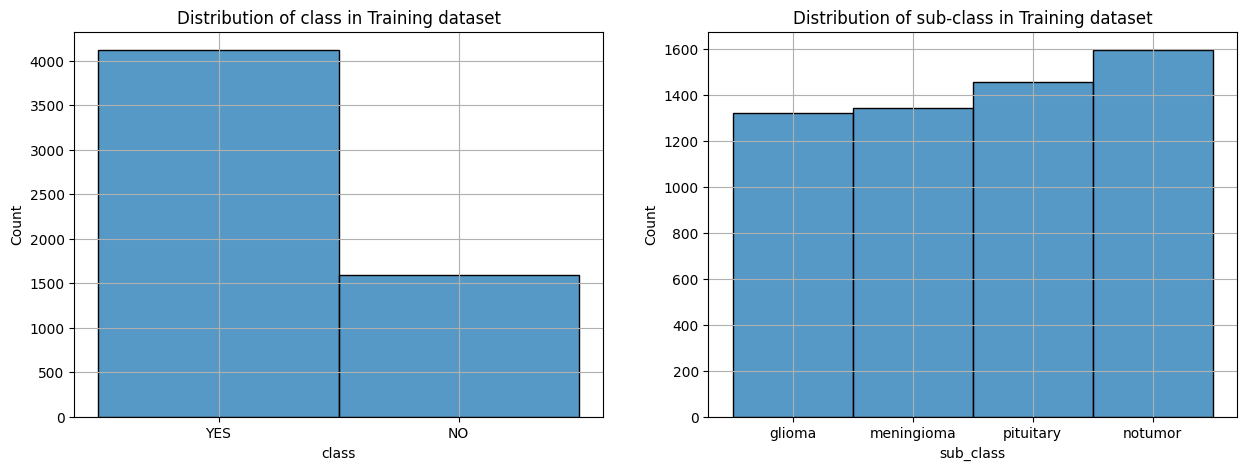

In [9]:
def show_class_distribution(df: pd.DataFrame, mode: str) -> None:
  """クラスの分布を表示する
  Args:
    df: データセットのメタデータ
    mode: 作成したいデータセットの種類（Training or Testing）

  Returns:
    None: 分布を表示
  """

  fig, axes = plt.subplots(1,2, figsize=(15, 5))
  sns.histplot(df["class"], ax=axes[0])
  sns.histplot(df["sub_class"], ax=axes[1])

  axes[0].set_title(f"Distribution of class in {mode} dataset")
  axes[1].set_title(f"Distribution of sub-class in {mode} dataset")
  axes[0].grid()
  axes[1].grid()
  plt.show()

show_class_distribution(train_df, "Training")

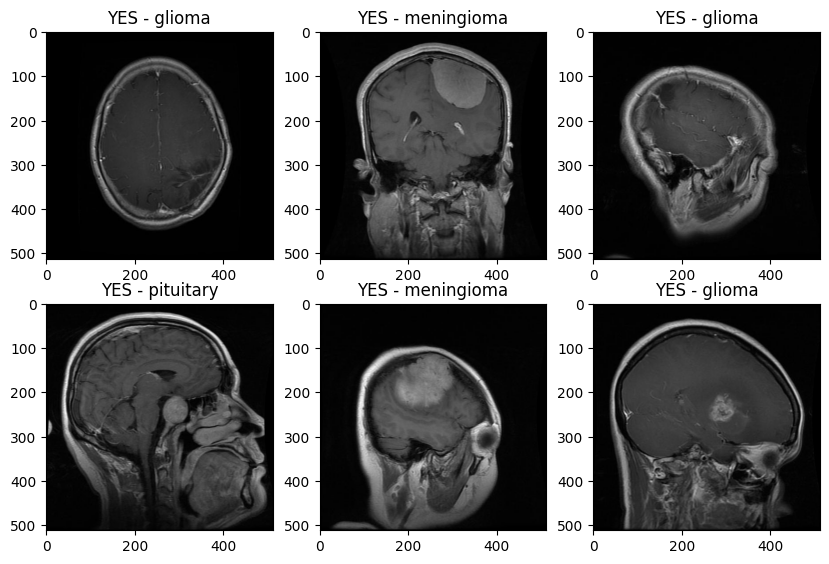

In [10]:
def show_images(data_path: str, df: pd.DataFrame, mode: str, num_images=6) -> None:
  """いくつかのMRI画像を表示する
  Args:
    data_path: データセットのディレクトリパス
    df: メタデータ
    mode: 作成したいデータセットの種類（Training or Testing）
    num_images: 表示したい画像の枚数

  Returns:
    None: MRI画像を表示
  """
  random_integers = random.sample(range(0, df.shape[0]), num_images)
  images = []
  classes = []
  sub_classes = []
  for i in range(0, len(random_integers)):
    images.append(cv2.imread(data_path + mode + "/" + df["class"][random_integers[i]] + "/" + df["sub_class"][random_integers[i]] + "/" + df["image_name"][random_integers[i]]))
    classes.append(df["class"][random_integers[i]])
    sub_classes.append(df["sub_class"][random_integers[i]])

  plt.figure(figsize=[10, 10])
  for x in range(0, len(random_integers)):
    plt.subplot(3,3, x+1)
    plt.imshow(images[x])
    plt.title(f"{classes[x]} - {sub_classes[x]}")
    x += 1
  plt.show()

show_images(data_path=ARGS["DATA_PATH"], df=train_df, mode="Training")


In [11]:
print(f"unique sub_classes: {train_df['sub_class'].unique()}")
print("腫瘍ありのクラスの割合:",train_df[train_df["class_int"] == 1].shape[0] / train_df.shape[0])
print("腫瘍なしのクラスの割合:",train_df[train_df["class_int"] == 0].shape[0] / train_df.shape[0])

unique sub_classes: ['glioma' 'meningioma' 'pituitary' 'notumor']
腫瘍ありのクラスの割合: 0.7208610430521526
腫瘍なしのクラスの割合: 0.2791389569478474


### Sub classについて
・MRI画像は、腫瘍なし(nottumor)、髄膜腫(meningioma)、下垂体腫瘍(pituitary)、神経膠腫(glioma)の四種類ある。今回は、これらのうち腫瘍なし(nottumor)を腫瘍なし(NO)とし、他の三種類を腫瘍あり(YES)として、分類する。

In [12]:
def create_folds(df: pd.DataFrame, fold_num: int, random_seed: int, is_shuffle: bool) -> pd.DataFrame:
  """foldの情報付きのメタデータを作成
  Args:
    df: メタデータ
    fold_num: Fold数
    random_seed: シード値
    is_shuffle: シャッフルするかの真偽値

  Returns:
    pd.DataFrame: foldの情報付きのメタデータ
  """
  df["kfold"] = -1
  kf = KFold(n_splits=fold_num, shuffle=is_shuffle, random_state=random_seed)

  for i, (train_idx, val_idx) in enumerate(kf.split(df["image_name"], groups=df["class"])):
    df["kfold"].iloc[val_idx] = i

  return df

train_df = create_folds(df=train_df, fold_num=ARGS["FOLD_NUM"], random_seed=ARGS["RANDOM_SEED"], is_shuffle=ARGS["IS_SHUFFLE"])
display(train_df.head())
display(train_df.groupby("class").count())

<ipython-input-12-b71bca13b2e2>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,image_name,class,sub_class,class_int,kfold
1,Tr-gl_0220.jpg,YES,glioma,1,2
2,Tr-gl_0236.jpg,YES,glioma,1,2
3,Tr-gl_0354.jpg,YES,glioma,1,4
4,Tr-gl_0350.jpg,YES,glioma,1,4
5,Tr-gl_0300.jpg,YES,glioma,1,1


,image_name,sub_class,class_int,kfold
class,,,,
NO,1595,1595,1595,1595
YES,4119,4119,4119,4119


In [13]:
class CustomDataset(Dataset):
  def __init__(self, df, transform, data_type):
    self.df = df
    self.data_type = data_type
    self.image_paths = df["image_name"]
    self.labels = df["class"]
    self.sub_class_paths = df["sub_class"]
    self.class_int = df["class_int"]
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index: int):
    image_path = self.image_paths[index]
    class_path = self.labels[index]
    sub_class_path = self.sub_class_paths[index]
    class_int = self.class_int[index]

    if self.data_type == "train":
      image = cv2.imread(f'{ARGS["DATA_PATH"]}/Training/{class_path}/{sub_class_path}/{image_path}')
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      class_int = torch.tensor(class_int, dtype=torch.long)

      image = self.transform(image=image)["image"]

      return image, class_int

    if self.data_type == "test":
      image = cv2.imread(f'{ARGS["DATA_PATH"]}/Testing/{class_path}/{sub_class_path}/{image_path}')
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

      image = self.transform(image=image)["image"]

      return image

In [14]:
image_transform = albu.Compose([
    albu.Resize(ARGS["image_size"], ARGS["image_size"]),
    albu.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    AT.ToTensorV2()
])

In [15]:
def train_one_epoch(model, optimizer, train_loader, device, epoch):
  model.train()
  dataset_size = 0
  running_loss = 0.0
  running_score = []
  running_score_y = []

  # 混合精度学習(16bitと32bitのfloatを使うことで、gpuの使用効率が向上)
  scaler = GradScaler(enabled=ARGS["apex"])

  train_loss = []
  bar = tqdm(enumerate(train_loader), total=len(train_loader), position=0, colour="green")
  for step, (images, targets) in bar:
    images = images.to(device)
    targets = targets.to(device)

    batch_size = targets.size(0)
    # forward passの段階で混合精度学習をする
    with torch.cuda.amp.autocast(enabled=ARGS["apex"]):
      outputs = model(images)
      loss = criterion(ARGS, outputs, targets)
    # backward passの段階で混合精度学習をする
    scaler.scale(loss).backward()

    # 勾配爆発を防ぐために勾配クリッピングをする(勾配計算(loss.backward())と重み更新(optimizer.step())の間に行う)
    if ARGS["clip_grad_norm"] != "None":
      grad_norm = torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=ARGS["clip_grad_norm"])
    else:
      grad_norm = None

    # 重み更新の段階で混合精度学習をする
    scaler.step(optimizer)
    scaler.update()

    # モデル内のパラメータの勾配を初期化
    optimizer.zero_grad()

    #if scheduler is not None:
      #scheduler.step()

    train_loss.append(loss.item())
    running_loss += (loss.item() * batch_size)
    dataset_size += batch_size

    epoch_loss = running_loss / dataset_size

    running_score.append(outputs.detach().cpu().numpy())
    running_score_y.append(targets.detach().cpu().numpy())

    score = get_score(running_score_y, running_score)

    # プログレスバーの末尾に特定の文字列(epoch, train_loss, etc)を追加
    bar.set_postfix(Epoch=epoch, Train_loss=epoch_loss, Train_Acc=score[0], Train_Auc=score[1], LR=optimizer.param_groups[0]["lr"])

  if scheduler is not None:
    scheduler.step()

  gc.collect()
  return epoch_loss, score

In [16]:
@torch.no_grad()
def valid_one_epoch(args, model, optimizer, valid_loader, epoch):
  model.eval()

  dataset_size = 0
  running_loss = 0.0
  preds = []
  valid_targets = []
  softmax = nn.Softmax()

  bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
  for step, (images, targets) in enumerate(valid_loader):
    images = images.to(args["device"])
    targets = targets.to(args["device"])
    batch_size = targets.size(0)

    with torch.no_grad():
      outputs = model(images)
      predict = outputs.softmax(dim=1)
      loss = criterion(args, outputs, targets)

    running_loss += (loss.item() * batch_size)
    dataset_size += batch_size

    epoch_loss = running_loss / dataset_size

    preds.append(predict.detach().cpu().numpy())
    valid_targets.append(targets.detach().cpu().numpy())

    if len(set(np.concatenate(valid_targets))) == 1:
      continue
    score = get_score(valid_targets, preds)

    # プログレスバーの末尾に特定の文字列(epoch, valid_loss, etc)を追加
    bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Acc=score[0], Valid_Auc=score[1], LR=optimizer.param_groups[0]['lr'])

  return epoch_loss, preds, valid_targets, score

In [17]:
def one_fold(model, optimizer, schedulerr, device, num_epochs, fold):
  if torch.cuda.is_available():
    print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

  start = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_epoch_score = np.inf
  best_prediction = None
  best_score = -np.inf

  # 可視化のためのリスト
  train_accs = []
  valid_accs = []
  train_losses = []
  val_losses = []

  for epoch in range(1, 1+num_epochs):
    train_epoch_loss, train_score = train_one_epoch(model, optimizer, train_loader=train_loader, device=device, epoch=epoch)
    train_acc, train_auc = train_score

    val_epoch_loss, predictions, valid_targets, valid_score = valid_one_epoch(ARGS, model, optimizer, valid_loader, epoch=epoch)
    valid_acc, valid_auc = valid_score

    LOGGER.info(f'Epoch {epoch} - avg_train_loss: {train_epoch_loss:.4f}  avg_val_loss: {val_epoch_loss:.4f}')
    LOGGER.info(f'Epoch {epoch} - Train Acc: {train_acc:.4f}  Train Auc: {train_auc:.4f}  Valid Acc: {valid_acc:.4f}  Valid Auc: {valid_auc:.4f}')

    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)

    if valid_auc >= best_score:
      best_score = valid_auc

      print(f"{b_}Validation Score Improved ({best_epoch_score} ---> {valid_auc})")
      best_epoch_score = valid_auc
      best_model_wts = copy.deepcopy(model.state_dict())

      # 評価指標が最も良かったモデルを保存する
      PATH = ARGS["OUT_DIR"] + "/" + f"{ARGS['model_name']}-Fold-{fold}.onnx"
      dummy_input = torch.randn(1, 3, ARGS["image_size"], ARGS["image_size"]).to(device)

      torch.onnx.export(model, dummy_input, PATH, input_names=["Image"], output_names=["Output"])
      print(f"Model has been converted to ONNX{sr_}")

      best_prediction = np.concatenate(predictions, axis=0)[:, 1]

  end = time.time()
  time_elapsed = end - start

  LOGGER.info('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
  LOGGER.info("Best Score: {:.4f}".format(best_epoch_score))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, best_prediction, valid_targets, train_losses, train_accs, val_losses, valid_accs

In [18]:
def create_model(args):
  model = timm.create_model('tf_efficientnetv2_m', pretrained=True, num_classes=args["num_classes"])
  #model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)
  # fine-tuniing(最終層をクラスの数に合うように全結合層を入れる)
  #model.heads[0] = torch.nn.Linear(in_features=model.heads[0].in_features, out_features=args["num_classes"], bias=True)
  return model

def criterion(args, outputs, labels):
  if args["criterion"] == "CrossEntropy":
    class_weights = torch.tensor([(train_df[train_df["class_int"] == 1].shape[0] / train_df.shape[0]), (100.0)]).to(args["device"])
    return nn.CrossEntropyLoss(weight=class_weights).to(args["device"])(outputs, labels)

  elif args["criterion"] == "None":
    return None

def fetch_optimizer(optimizer_parameters, lr, betas, optimizer_name="Adam"):
    if optimizer_name == "Adam":
        optimizer = optim.Adam(optimizer_parameters, lr=lr)

    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(optimizer_parameters, lr=lr, betas=betas)

    return optimizer

def fetch_scheduler(args, train_size, optimizer):
  if args["scheduler"] == "CosineAnnealingLR":
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=args["T_max"], eta_min=args["min_lr"])

  elif args["scheduler"] == 'CosineAnnealingWarmRestarts':
    scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=args['T_0'], eta_min=args['min_lr'])

  elif args['scheduler'] == "None":
    scheduler = None

  return scheduler

def get_score(y_trues, y_preds):
  predict_list, targets_list = np.concatenate(y_preds, axis=0), np.concatenate(y_trues)
  predict_list_proba = predict_list.copy()[:, 1]
  predict_list = predict_list.argmax(axis=1)

  accuracy = accuracy_score(predict_list, targets_list)
  auc_score = roc_auc_score(targets_list, predict_list_proba)

  return (accuracy, auc_score)

def prepare_loaders(args, train, image_transform, fold):
    df_train = train[train.kfold != fold].reset_index(drop=True)
    df_valid = train[train.kfold == fold].reset_index(drop=True)

    train_dataset = CustomDataset(df_train, image_transform, data_type="train")
    valid_dataset = CustomDataset(df_valid, image_transform, data_type="train")

    train_loader = DataLoader(train_dataset, batch_size=args['train_batch_size'],
                              worker_init_fn=worker_init_fn(args["RANDOM_SEED"]),
                              num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=args['test_batch_size'],
                              num_workers=2,
                              shuffle=False, pin_memory=True)

    return train_loader, valid_loader

In [19]:
result_dict = {}
train_copy = train_df.copy()
LOGGER.info(ARGS)
for fold in range(0, ARGS["FOLD_NUM"]):
  print(f"{y_}====== Fold: {fold} ======{sr_}")
  LOGGER.info(f"========== fold: {fold} training ==========")

  # Create Dataloaders
  train_loader, valid_loader = prepare_loaders(args=ARGS, train=train_df, image_transform=image_transform, fold=fold)

  model = create_model(ARGS)
  model = model.to(ARGS["device"])

  #損失関数・最適化関数の定義
  optimizer = fetch_optimizer(model.parameters(), optimizer_name=ARGS["optimizer"], lr=ARGS["learning_rate"], betas=(0.9, 0.999))
  scheduler = fetch_scheduler(args=ARGS, train_size=len(train_loader), optimizer=optimizer)

  # 1-fold分の学習をする
  model, predictions, targets, train_losses, train_accs, val_losses, valid_accs = one_fold(model, optimizer, scheduler, device=ARGS["device"], num_epochs=ARGS["epochs"], fold=fold)

  # 予測結果を記録する
  train_copy.loc[train_copy[train_copy.kfold == fold].index, "oof"] = predictions

  # 損失と評価指標の推移を記録する
  result_dict[f"train_losses_(fold_{fold})"] = train_losses
  result_dict[f"train_accs_(fold_{fold})"] = train_accs
  result_dict[f"val_losses_(fold_{fold})"] = val_losses
  result_dict[f"valid_accs_(fold_{fold})"] = valid_accs

  del model, train_loader, valid_loader
  _ = gc.collect()
  torch.cuda.empty_cache()
  print()

scores = roc_auc_score(train_copy["class_int"].values, train_copy["oof"].values)
LOGGER.info(f"========== CV ==========")
LOGGER.info(f"CV: {scores:.4f}")

INFO:__main__:{'RANDOM_SEED': 123, 'DATA_PATH': '/content/drive/MyDrive/Colab Notebooks/BrainMRI-images-classification/datasets/', 'OUT_DIR': '/content/drive/MyDrive/Colab Notebooks/BrainMRI-images-classification/results/', 'criterion': 'CrossEntropy', 'clip_grad_norm': 'None', 'model_name': 'efficientnet_v2_m', 'scheduler': 'CosineAnnealingLR', 'optimizer': 'AdamW', 'learning_rate': 0.0001, 'TRAIN_NUM_IMAGES': 5714, 'TEST_NUM_IMAGES': 1311, 'FOLD_NUM': 5, 'epochs': 4, 'num_classes': 2, 'image_size': 480, 'train_batch_size': 16, 'test_batch_size': 32, 'min_lr': 1e-06, 'T_max': 500, 'IS_SHUFFLE': True, 'apex': True, 'device': device(type='cuda', index=0)}
INFO:__main__:========== fold: 0 training ==========


====== Fold: 0 ======
[INFO] Using GPU: Tesla T4



  0%|          | 0/36 [01:30<?, ?it/s, Epoch=1, LR=0.0001, Valid_Acc=0.933, Valid_Auc=0.97, Valid_Loss=0.763]
INFO:__main__:Epoch 1 - avg_train_loss: 0.1295  avg_val_loss: 0.7633
INFO:__main__:Epoch 1 - Train Acc: 0.8682  Train Auc: 0.9382  Valid Acc: 0.9326  Valid Auc: 0.9702


Validation Score Improved (inf ---> 0.9702374296470238)
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX


  0%|          | 0/36 [00:29<?, ?it/s, Epoch=2, LR=0.0001, Valid_Acc=0.927, Valid_Auc=0.984, Valid_Loss=0.539]
INFO:__main__:Epoch 2 - avg_train_loss: 0.0237  avg_val_loss: 0.5387
INFO:__main__:Epoch 2 - Train Acc: 0.9112  Train Auc: 0.9913  Valid Acc: 0.9274  Valid Auc: 0.9836


Validation Score Improved (0.9702374296470238 ---> 0.9835886540683589)
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX


  0%|          | 0/36 [00:30<?, ?it/s, Epoch=3, LR=0.0001, Valid_Acc=0.929, Valid_Auc=0.991, Valid_Loss=0.451]
INFO:__main__:Epoch 3 - avg_train_loss: 0.0126  avg_val_loss: 0.4511
INFO:__main__:Epoch 3 - Train Acc: 0.9230  Train Auc: 0.9967  Valid Acc: 0.9291  Valid Auc: 0.9914


Validation Score Improved (0.9835886540683589 ---> 0.9914048231391405)
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX


  0%|          | 0/36 [00:31<?, ?it/s, Epoch=4, LR=0.0001, Valid_Acc=0.984, Valid_Auc=0.998, Valid_Loss=0.073]
INFO:__main__:Epoch 4 - avg_train_loss: 0.0027  avg_val_loss: 0.0730
INFO:__main__:Epoch 4 - Train Acc: 0.9719  Train Auc: 0.9981  Valid Acc: 0.9843  Valid Auc: 0.9984


Validation Score Improved (0.9914048231391405 ---> 0.998359983599836)


INFO:__main__:Training complete in 0h 19m 21s
INFO:__main__:Best Score: 0.9984


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX


INFO:__main__:========== fold: 1 training ==========



====== Fold: 1 ======
[INFO] Using GPU: Tesla T4



  0%|          | 0/36 [00:31<?, ?it/s, Epoch=1, LR=0.0001, Valid_Acc=0.9, Valid_Auc=0.953, Valid_Loss=1.04]
INFO:__main__:Epoch 1 - avg_train_loss: 0.1257  avg_val_loss: 1.0415
INFO:__main__:Epoch 1 - Train Acc: 0.8636  Train Auc: 0.9075  Valid Acc: 0.9003  Valid Auc: 0.9535


Validation Score Improved (inf ---> 0.9534760541081698)
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX


  0%|          | 0/36 [00:30<?, ?it/s, Epoch=2, LR=0.0001, Valid_Acc=0.969, Valid_Auc=0.997, Valid_Loss=0.127]
INFO:__main__:Epoch 2 - avg_train_loss: 0.0270  avg_val_loss: 0.1272
INFO:__main__:Epoch 2 - Train Acc: 0.8860  Train Auc: 0.9794  Valid Acc: 0.9694  Valid Auc: 0.9971


Validation Score Improved (0.9534760541081698 ---> 0.9971285107836061)
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX


  0%|          | 0/36 [00:29<?, ?it/s, Epoch=3, LR=0.0001, Valid_Acc=0.959, Valid_Auc=1, Valid_Loss=0.168]
INFO:__main__:Epoch 3 - avg_train_loss: 0.0026  avg_val_loss: 0.1678
INFO:__main__:Epoch 3 - Train Acc: 0.9715  Train Auc: 0.9989  Valid Acc: 0.9589  Valid Auc: 0.9996


Validation Score Improved (0.9971285107836061 ---> 0.9996236020892024)
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX


  0%|          | 0/36 [00:29<?, ?it/s, Epoch=4, LR=0.0001, Valid_Acc=0.981, Valid_Auc=1, Valid_Loss=0.068]
INFO:__main__:Epoch 4 - avg_train_loss: 0.0021  avg_val_loss: 0.0680
INFO:__main__:Epoch 4 - Train Acc: 0.9739  Train Auc: 0.9993  Valid Acc: 0.9808  Valid Auc: 0.9995
INFO:__main__:Training complete in 0h 16m 13s
INFO:__main__:Best Score: 0.9996
INFO:__main__:========== fold: 2 training ==========



====== Fold: 2 ======
[INFO] Using GPU: Tesla T4



  0%|          | 0/36 [00:29<?, ?it/s, Epoch=1, LR=0.0001, Valid_Acc=0.958, Valid_Auc=0.996, Valid_Loss=0.223]
INFO:__main__:Epoch 1 - avg_train_loss: 0.1300  avg_val_loss: 0.2228
INFO:__main__:Epoch 1 - Train Acc: 0.8515  Train Auc: 0.9008  Valid Acc: 0.9580  Valid Auc: 0.9955


Validation Score Improved (inf ---> 0.9955298603057658)
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX


  0%|          | 0/36 [00:30<?, ?it/s, Epoch=2, LR=0.0001, Valid_Acc=0.937, Valid_Auc=0.994, Valid_Loss=0.322]
INFO:__main__:Epoch 2 - avg_train_loss: 0.0121  avg_val_loss: 0.3220
INFO:__main__:Epoch 2 - Train Acc: 0.9151  Train Auc: 0.9903  Valid Acc: 0.9370  Valid Auc: 0.9941
  0%|          | 0/36 [00:29<?, ?it/s, Epoch=3, LR=0.0001, Valid_Acc=0.963, Valid_Auc=0.999, Valid_Loss=0.136]
INFO:__main__:Epoch 3 - avg_train_loss: 0.0160  avg_val_loss: 0.1358
INFO:__main__:Epoch 3 - Train Acc: 0.9132  Train Auc: 0.9934  Valid Acc: 0.9633  Valid Auc: 0.9990


Validation Score Improved (0.9955298603057658 ---> 0.9990449553175523)
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX


  0%|          | 0/36 [00:29<?, ?it/s, Epoch=4, LR=0.0001, Valid_Acc=0.96, Valid_Auc=0.999, Valid_Loss=0.169]
INFO:__main__:Epoch 4 - avg_train_loss: 0.0046  avg_val_loss: 0.1694
INFO:__main__:Epoch 4 - Train Acc: 0.9686  Train Auc: 0.9987  Valid Acc: 0.9598  Valid Auc: 0.9993


Validation Score Improved (0.9990449553175523 ---> 0.9992590823991329)


INFO:__main__:Training complete in 0h 15m 27s
INFO:__main__:Best Score: 0.9993


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX


INFO:__main__:========== fold: 3 training ==========



====== Fold: 3 ======
[INFO] Using GPU: Tesla T4



  0%|          | 0/36 [00:29<?, ?it/s, Epoch=1, LR=0.0001, Valid_Acc=0.962, Valid_Auc=0.995, Valid_Loss=0.195]
INFO:__main__:Epoch 1 - avg_train_loss: 0.0978  avg_val_loss: 0.1955
INFO:__main__:Epoch 1 - Train Acc: 0.8570  Train Auc: 0.9329  Valid Acc: 0.9615  Valid Auc: 0.9950


Validation Score Improved (inf ---> 0.9950142938822184)
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX


  0%|          | 0/36 [00:30<?, ?it/s, Epoch=2, LR=0.0001, Valid_Acc=0.9, Valid_Auc=0.966, Valid_Loss=1.07]
INFO:__main__:Epoch 2 - avg_train_loss: 0.0178  avg_val_loss: 1.0740
INFO:__main__:Epoch 2 - Train Acc: 0.9232  Train Auc: 0.9862  Valid Acc: 0.9003  Valid Auc: 0.9664
  0%|          | 0/36 [00:29<?, ?it/s, Epoch=3, LR=0.0001, Valid_Acc=0.935, Valid_Auc=0.997, Valid_Loss=0.26]
INFO:__main__:Epoch 3 - avg_train_loss: 0.0091  avg_val_loss: 0.2596
INFO:__main__:Epoch 3 - Train Acc: 0.9432  Train Auc: 0.9919  Valid Acc: 0.9353  Valid Auc: 0.9973


Validation Score Improved (0.9950142938822184 ---> 0.9973432437583382)
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX


  0%|          | 0/36 [00:30<?, ?it/s, Epoch=4, LR=0.0001, Valid_Acc=0.945, Valid_Auc=0.999, Valid_Loss=0.264]
INFO:__main__:Epoch 4 - avg_train_loss: 0.0021  avg_val_loss: 0.2639
INFO:__main__:Epoch 4 - Train Acc: 0.9726  Train Auc: 0.9992  Valid Acc: 0.9449  Valid Auc: 0.9993


Validation Score Improved (0.9973432437583382 ---> 0.9992948351438916)


INFO:__main__:Training complete in 0h 15m 28s
INFO:__main__:Best Score: 0.9993


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX


INFO:__main__:========== fold: 4 training ==========



====== Fold: 4 ======
[INFO] Using GPU: Tesla T4



  0%|          | 0/36 [00:29<?, ?it/s, Epoch=1, LR=0.0001, Valid_Acc=0.849, Valid_Auc=0.95, Valid_Loss=1.49]
INFO:__main__:Epoch 1 - avg_train_loss: 0.0980  avg_val_loss: 1.4904
INFO:__main__:Epoch 1 - Train Acc: 0.8513  Train Auc: 0.9369  Valid Acc: 0.8485  Valid Auc: 0.9503


Validation Score Improved (inf ---> 0.9502934709874773)
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX


  0%|          | 0/36 [00:30<?, ?it/s, Epoch=2, LR=0.0001, Valid_Acc=0.947, Valid_Auc=0.992, Valid_Loss=0.331]
INFO:__main__:Epoch 2 - avg_train_loss: 0.0059  avg_val_loss: 0.3310
INFO:__main__:Epoch 2 - Train Acc: 0.9401  Train Auc: 0.9929  Valid Acc: 0.9466  Valid Auc: 0.9924


Validation Score Improved (0.9502934709874773 ---> 0.9924462288500144)
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX


  0%|          | 0/36 [00:29<?, ?it/s, Epoch=3, LR=0.0001, Valid_Acc=0.961, Valid_Auc=0.996, Valid_Loss=0.193]
INFO:__main__:Epoch 3 - avg_train_loss: 0.0046  avg_val_loss: 0.1931
INFO:__main__:Epoch 3 - Train Acc: 0.9614  Train Auc: 0.9984  Valid Acc: 0.9615  Valid Auc: 0.9962


Validation Score Improved (0.9924462288500144 ---> 0.9961953924099034)
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX


  0%|          | 0/36 [00:29<?, ?it/s, Epoch=4, LR=0.0001, Valid_Acc=0.976, Valid_Auc=1, Valid_Loss=0.109]
INFO:__main__:Epoch 4 - avg_train_loss: 0.0086  avg_val_loss: 0.1095
INFO:__main__:Epoch 4 - Train Acc: 0.9436  Train Auc: 0.9970  Valid Acc: 0.9764  Valid Auc: 0.9996


Validation Score Improved (0.9961953924099034 ---> 0.9996443934614281)


INFO:__main__:Training complete in 0h 16m 26s
INFO:__main__:Best Score: 0.9996


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been converted to ONNX



KeyError: ignored

INFO:__main__:========== CV ==========
INFO:__main__:CV: 0.9993


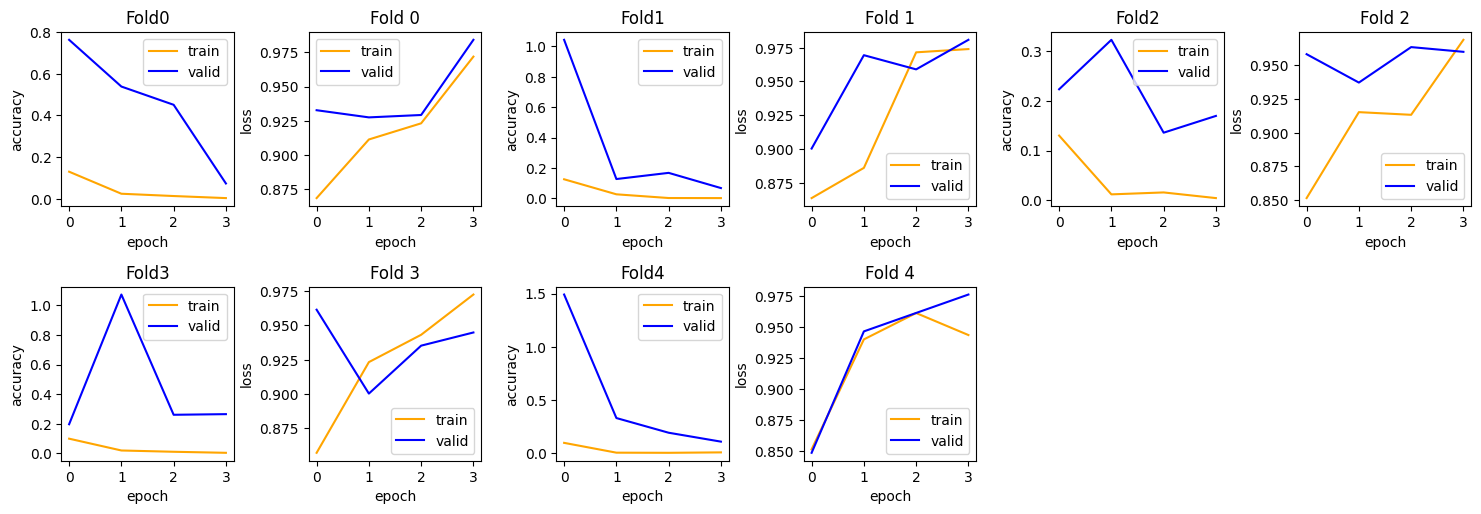

In [40]:
import math
def show_validation_score(args: dict, results: dict, save=False, save_name='classification_validation_score.png') -> None:
  """推論結果を可視化する
  Args:
    args: 設定した変数のdict
    results: 推論結果を保存したdict
    save: 可視化した結果を保存するか否かの真偽値
    save_name: 保存する結果の名前

  Returns:
    None: 推論結果を可視化
  """
  fig = plt.figure(figsize=(15, 15))
  for i in range(args["FOLD_NUM"]):
    train_acc = results[f"train_accs_(fold_{i})"]
    train_loss = results[f"train_losses_(fold_{i})"]
    valid_acc = results[f"valid_accs_(fold_{i})"]
    val_loss = results[f"val_losses_(fold_{i})"]

    ax = fig.add_subplot(math.ceil(np.sqrt(args["FOLD_NUM"]))*2,
                         math.ceil(np.sqrt(args["FOLD_NUM"]))*2, (i*2)+1, title=f"Fold{i}")
    ax.plot(range(args["epochs"]), train_acc, c="orange", label="train")
    ax.plot(range(args["epochs"]), valid_acc, c="blue", label="valid")
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.legend()

    ax = fig.add_subplot(math.ceil(np.sqrt(args["FOLD_NUM"]))*2,
                         math.ceil(np.sqrt(args["FOLD_NUM"]))*2, (i*2)+2, title=f'Fold {i}')
    ax.plot(range(args["epochs"]), train_loss, c='orange', label='train')
    ax.plot(range(args["epochs"]), val_loss, c='blue', label='valid')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend()

  plt.tight_layout()

  if save:
      os.makedirs(args["IMAGE_SAVE_DIR"], exist_ok=True)
      plt.savefig(args["IMAGE_SAVE_DIR"]+save_name)
  else:
      plt.show()

show_validation_score(args=ARGS, results=result_dict)

{'train_accs_(fold_0)': [0.12951690518380343,
  0.02365273575149343,
  0.012638236104104061,
  0.002712365618381889],
 'train_losses_(fold_0)': [0.8682017543859649,
  0.9111842105263158,
  0.9230263157894737,
  0.9719298245614035],
 'valid_accs_(fold_0)': [0.7632872242369703,
  0.5387339202292465,
  0.4510601433828085,
  0.07297943112391936],
 'val_losses_(fold_0)': [0.9326334208223972,
  0.9273840769903762,
  0.9291338582677166,
  0.984251968503937],
 'train_accs_(fold_1)': [0.12569293318573815,
  0.02695119022127802,
  0.0025972722391708137,
  0.0021045967797435716],
 'train_losses_(fold_1)': [0.8635964912280701,
  0.8859649122807017,
  0.9714912280701754,
  0.9739035087719298],
 'valid_accs_(fold_1)': [1.0414971542697604,
  0.12724298078866536,
  0.16780003895629816,
  0.06800148995531019],
 'val_losses_(fold_1)': [0.9002624671916011,
  0.9693788276465442,
  0.9588801399825022,
  0.9807524059492564],
 'train_accs_(fold_2)': [0.12997131846273086,
  0.012079796140522263,
  0.015955515

In [ ]:
# 予測確率をクラスに変換
condition = [train_copy["oof"] >= 0.5]
train_copy["pred_label"] = np.select(condition, [1], 0)
train_copy

In [ ]:
# test用のデータ拡張
image_transform_test = albu.Compose([
    albu.Resize(ARGS["image_size"], ARGS["image_size"]),
    albu.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    AT.ToTensorV2()
])
test_dataset = CustomDataset(test_df, image_transform_test, data_type="test")
test_loader = DataLoader(test_dataset, batch_size=ARGS["test_batch_size"], shuffle=False, num_workers=2)

In [ ]:
MODEL_PATH = [ARGS["OUT_DIR"] + "/" + f"{ARGS['model_name']}-Fold-{fold}.onnx" for i in range(ARGS["FOLD_NUM"])]

